<a href="https://colab.research.google.com/github/LinkCatList/nlp-anime-project/blob/main/Copy_of_dataset5_epoch%3D7_pl%3D150.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

!pip install livelossplot --quiet
!pip install tqdm --quiet
!pip install wandb --quiet
!pip install ipywidgets --quiet
!jupyter nbextension enable --py widgetsnbextension
!pip install wandb --quiet
!pip install captum --quiet

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import glob
from random import randint

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm.notebook import tqdm
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from torchvision import transforms
from matplotlib.colors import LinearSegmentedColormap
import captum
import os
import wandb

In [ ]:
!wandb login(key='fb1cc77c471b4bfeebd9aafbd2a4de51f0ce42c9')

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `wandb login(key='fb1cc77c471b4bfeebd9aafbd2a4de51f0ce42c9')'


In [ ]:
!unzip -o '/content/drive/MyDrive/dataset5.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Training/meningioma/M_36_HF_.jpg  
  inflating: Training/meningioma/M_36_RO_.jpg  
  inflating: Training/meningioma/M_36_SP_.jpg  
  inflating: Training/meningioma/M_36_VF_.jpg  
  inflating: Training/meningioma/M_37.jpg  
  inflating: Training/meningioma/M_37_BR_.jpg  
  inflating: Training/meningioma/M_37_DA_.jpg  
  inflating: Training/meningioma/M_37_HF_.jpg  
  inflating: Training/meningioma/M_37_RO_.jpg  
  inflating: Training/meningioma/M_37_SP_.jpg  
  inflating: Training/meningioma/M_37_VF_.jpg  
  inflating: Training/meningioma/M_38.jpg  
  inflating: Training/meningioma/M_38_BR_.jpg  
  inflating: Training/meningioma/M_38_DA_.jpg  
  inflating: Training/meningioma/M_38_HF_.jpg  
  inflating: Training/meningioma/M_38_RO_.jpg  
  inflating: Training/meningioma/M_38_SP_.jpg  
  inflating: Training/meningioma/M_38_VF_.jpg  
  inflating: Training/meningioma/M_39.jpg  
  inflating: Training/meningioma

In [ ]:
device = 'cpu'

In [ ]:
BATCH_SIZE = 8

class CustomDataset(Dataset):
    def __init__(self, data_path):
        self.imgs_path = data_path
        file_list = glob.glob(self.imgs_path + "*")

        print('Folders:')
        print(file_list)
        print('\n Classes:')

        self.data = []
        self.class_counter = {'glioma': 0, 'meningioma': 0, 'notumor': 0, 'pituitary': 0}
        for class_path in os.listdir(self.imgs_path):
          class_name = class_path.split("/")[-1]
          for img_path in os.listdir(self.imgs_path + class_name):
            self.data.append([self.imgs_path + class_path + '/' + img_path, class_name])
            self.class_counter[class_name] += 1

        self.class_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

        print(self.class_map)
        print('\nExamples:')

        for i in range(3):
          print(self.data[randint(0, len(self.data))])
        self.img_dim = (180, 180)


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.cvtColor(cv2.resize(cv2.imread(img_path, 0), self.img_dim), cv2.COLOR_GRAY2RGB)
        img_tensor = torch.from_numpy(np.array(img).astype(np.float32)).to(device)
        img_tensor = img_tensor.permute(2, 0, 1) / 255
        class_id = torch.tensor(self.class_map[class_name]).to(device)
        return img_tensor, class_id

def show_images(images, labels):
    f, axes= plt.subplots(1, BATCH_SIZE, figsize=(30, 5))
    for i, axis in enumerate(axes):
        img = (images[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        axes[i].imshow(img, cmap=plt.get_cmap('gray'))
        axes[i].set_title(labels[i].numpy())

    plt.show()

In [ ]:
print("\nTrain data:")
train_dataset = CustomDataset('/content/Training/')
print("\nValidation data:")
validation_dataset = CustomDataset('/content/Testing/')

train_data_size = int(len(train_dataset) * 0.8)
test_data_size = len(train_dataset) - train_data_size

train_data, test_data = torch.utils.data.random_split(train_dataset, [train_data_size, test_data_size])

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader =  DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=True)

validation_data_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)


Train data:
Folders:
['/content/Training/notumor', '/content/Training/glioma', '/content/Training/pituitary', '/content/Training/meningioma']

 Classes:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Examples:
['/content/Training/pituitary/P_541_BR_.jpg', 'pituitary']
['/content/Training/pituitary/P_417_VF_.jpg', 'pituitary']
['/content/Training/glioma/G_134_RO_.jpg', 'glioma']

Validation data:
Folders:
['/content/Testing/notumor', '/content/Testing/glioma', '/content/Testing/pituitary', '/content/Testing/meningioma']

 Classes:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Examples:
['/content/Testing/notumor/N_104_DA_.jpg', 'notumor']
['/content/Testing/meningioma/M_50_BR_.jpg', 'meningioma']
['/content/Testing/glioma/G_268_VF_.jpg', 'glioma']


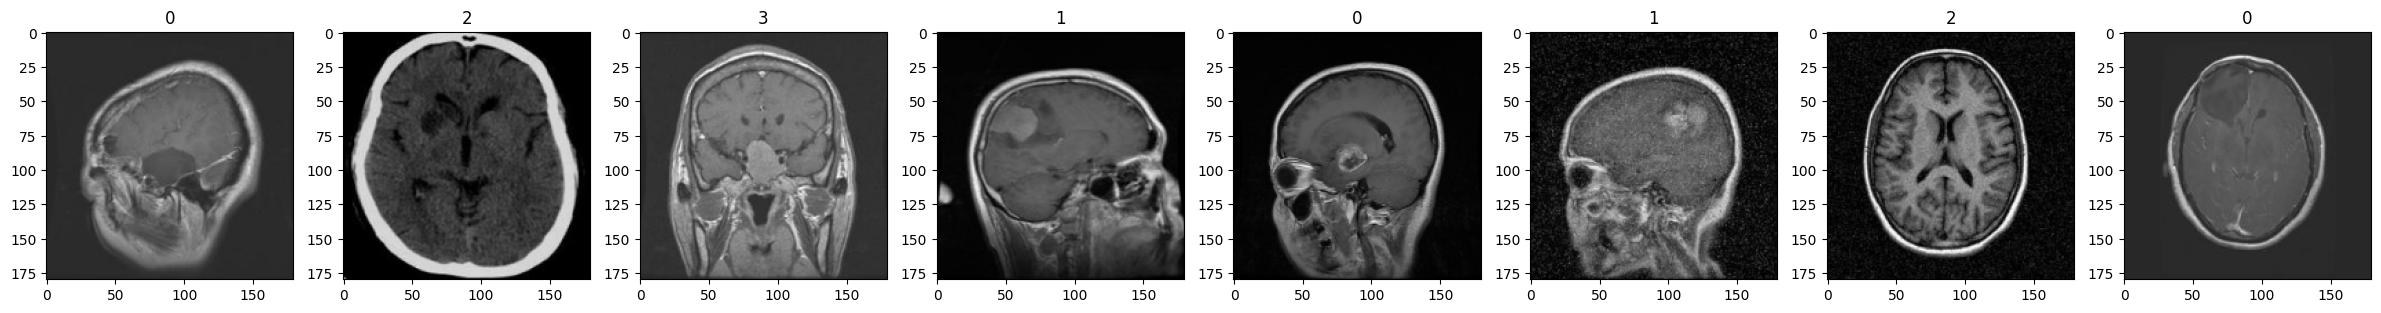

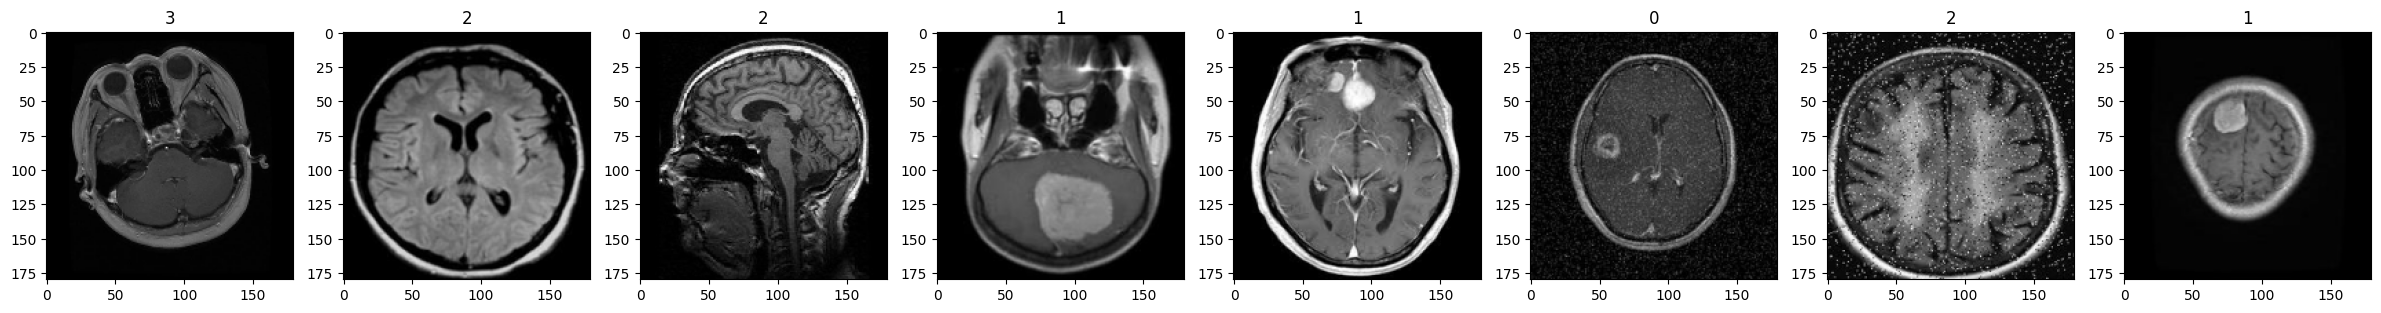

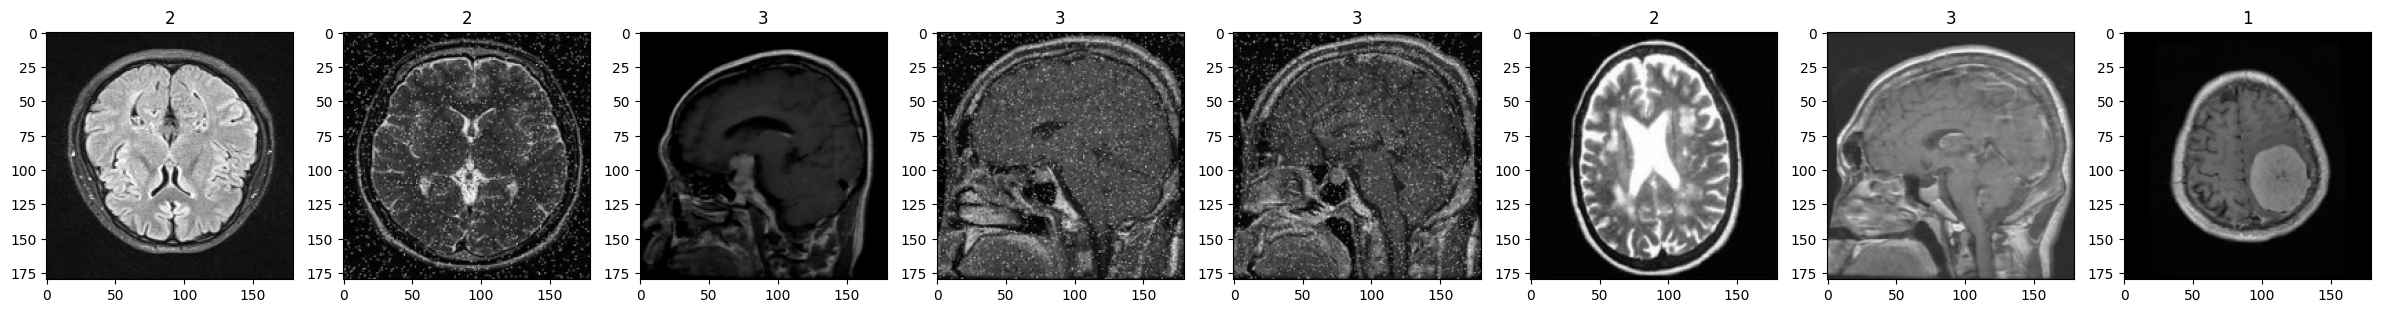

In [ ]:
for imgs, labels in train_data_loader:
    images = imgs
    labls = labels
    break

show_images(images.cpu(), labels.cpu())


for imgs, labels in test_data_loader:
    images = imgs
    labls = labels
    break

show_images(images.cpu(), labels.cpu())

for imgs, labels in validation_data_loader:
    images = imgs
    labls = labels
    break

show_images(images.cpu(), labels.cpu())

In [ ]:

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(8, 16, 8, padding=1)
        self.dropout2 = nn.Dropout(0.25)

        self.batchnorm2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(16, 32, 2, padding=1)
        self.dropout3 = nn.Dropout(0.25)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(32, 16, 16, padding=1)
        self.dropout4 = nn.Dropout(0.25)
        self.batchnorm4 = nn.BatchNorm2d(16)

        self.flatten = nn.Flatten()

        self.fc_2_1 = nn.Linear(28224, 512)
        self.fc_2_2 = nn.Linear(512, 4)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 4)


    def forward(self, x):
        x = func.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)

        x = func.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)

        x_1 = func.relu(self.conv3(x))
        x_1 = self.dropout3(x_1)
        x_1 = self.batchnorm3(x_1)
        x_1 = self.pool3(x_1)

        x_1 = func.relu(self.conv4(x_1))
        x_1 = self.dropout4(x_1)
        x_1 = self.batchnorm4(x_1)

        x_1 = self.flatten(x_1)
        x_1 = func.relu(self.fc1(x_1))
        x_1 = self.fc2(x_1)

        x_2 = self.flatten(x)
        x_2 = func.relu(self.fc_2_1(x_2))
        x_2 = self.fc_2_2(x_2)

        return x_1 + x_2


In [ ]:
def evaluate(model, dataloader, loss_fn, device, epoch=None):
    losses = []
    num_correct = 0
    num_elements = len(dataloader)
    print(num_elements)
    for images, labels in tqdm(dataloader):
        with torch.no_grad():
            predicted = model(images)

            loss = loss_fn(predicted, labels)
            losses.append(loss.item())

            num_correct += sum(torch.argmax(predicted, dim=1)==labels).item()

    print(num_elements, num_correct, BATCH_SIZE)

    accuracy = num_correct / (num_elements * BATCH_SIZE)
    if epoch is not None:
      print(f"Epoch: {epoch}, Accuracy_test: {accuracy}, Loss_test: {np.mean(losses)}")
    return accuracy, np.mean(losses)

In [ ]:
class_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
class_counter = [0, 0, 0, 0]
for element in train_data:
  class_counter[int(element[1])] += 1

In [ ]:
conv_net = ConvNet()
conv_net = conv_net.to(device)

print(class_counter)
weights = [sum(class_counter) / (len(class_counter) * class_counter[i]) for i in range(len(class_counter))]
weights[0] *= 1.02
print(weights)

class_weights=torch.FloatTensor(weights).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 1e-3
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

[4993, 5077, 5143, 4769]
[1.0205107150010015, 0.9839472129210164, 0.9713202411044137, 1.047494233591948]


In [ ]:
def train(model, loss_fn, optimizer, n_epoch=10, device='cpu', plot_every=100):
    wandb.init(settings=wandb.Settings(start_method="thread"))

    for epoch in range(n_epoch):
        clear_output(wait=True)
        print(f"Epoch: {epoch}")
        model.train(True)
        current_loss = 0
        total_correct = 0
        total_instances = 0
        ind = 0
        for images, labels in tqdm(train_data_loader):

            y_hat = model(images)
            predicted = torch.argmax(y_hat, dim=1)

            loss = loss_fn(y_hat, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            current_loss += loss.item()


            correct_predictions = sum(predicted==labels).item()

            total_correct += correct_predictions
            total_instances += len(images)


            if ind % (plot_every // BATCH_SIZE * 4) == 0:
              wandb.log({
                  'train/loss_train': loss.item(),
                  'train/accuracy_train': round(total_correct/total_instances, 3),
              })

            ind += 1

        model.eval()
        test_accuracy, test_loss = evaluate(model, test_data_loader, loss_fn=loss_fn, device=device, epoch=epoch)

        wandb.log({
                  'train/loss_test': test_loss,
                  'train/accuracy_test': test_accuracy,
              })

        model.train(False)

In [ ]:
train(conv_net, loss_fn, optimizer, n_epoch=7, plot_every=150)

Epoch: 6


  0%|          | 0/2498 [00:00<?, ?it/s]

625


  0%|          | 0/625 [00:00<?, ?it/s]

625 4328 8
Epoch: 6, Accuracy_test: 0.8656, Loss_test: 0.5540367475356859


In [ ]:
conv_net.to(device)
val_accuracy, val_loss = evaluate(conv_net, validation_data_loader, loss_fn=loss_fn, device=device)
print(val_accuracy, val_loss)
conv_net.to('cpu')

paths = f'/content/drive/MyDrive/model_final_dataset5_7_150'
torch.save(conv_net, paths)

482


  0%|          | 0/482 [00:00<?, ?it/s]

482 3563 8
0.9240145228215768 0.28521434042826926


In [ ]:
paths = '/content/drive/MyDrive/model_final_dataset5_7_150'
model = torch.load(paths)
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.25, inplace=False)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout(p=0.25, inplace=False)
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 16, kernel_size=(16, 16), stride=(1, 1), padding=(1, 1))
  (dropout4): Dropo

In [ ]:
def get_class_of_tumor(idx):
  classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
  return classes[idx]

In [ ]:
def get_segmented_map(image_attr: np.array,
                           color_map: str ='positive',
                           borders: tuple = (20, 20)) -> np.array:
  if color_map != 'all':
    for i in range(len(image_attr)):
      for j in range(len(image_attr[i])):
        flag_zero = False
        if color_map == 'positive':
          if max(image_attr[i][j]) != image_attr[i][j][1]:
            flag_zero = True
          else:
            if sum(image_attr[i][j]) - max(image_attr[i][j]) > borders[1]:
              flag_zero = True
        elif color_map == 'negative':
          if max(image_attr[i][j]) == image_attr[i][j][1] or max(image_attr[i][j]) == image_attr[i][j][2]:
            flag_zero = True
          else:
            if sum(image_attr[i][j]) - max(image_attr[i][j]) > borders[0]:
              flag_zero = True
        if flag_zero:
          image_attr[i][j] = [0, 0, 0]
  return image_attr

In [ ]:
def show_pack_of_images(images, labels):
    f, axes = plt.subplots(1, len(images), figsize=(30, 5))
    for i, axis in enumerate(axes):
        img = images[i]
        axes[i].imshow(img)
        axes[i].set_title(labels[i])
    plt.show()

In [ ]:
def create_color_map_igrad(net, img_path: str) -> tuple:
  integrated_gradients = IntegratedGradients(net)
  img = cv2.cvtColor(cv2.resize(cv2.imread(img_path, 0), (180, 180)), cv2.COLOR_GRAY2RGB)
  img_tensor = torch.from_numpy(np.array(img).astype(np.float32)).to('cpu')
  img_tensor = img_tensor.permute(2, 0, 1) / 255
  img_tensor = img_tensor.unsqueeze(0)

  output = model(img_tensor)
  prediction_score, pred_label_idx = torch.topk(output, 1)
  print(prediction_score, pred_label_idx, output)
  pred_label_idx.squeeze_()
  predicted_label = pred_label_idx.item()


  attributions_ig = integrated_gradients.attribute(img_tensor, target=pred_label_idx, n_steps=200)

  default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                  [(0, '#ffffff'),
                                                   (0.25, '#000000'),
                                                   (1, '#000000')], N=256)

  imgs = [(img_tensor.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8),
          (np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)) * 255).astype(np.uint8)]
  imgs.extend([get_segmented_map(imgs[1].copy(), 'negative'), get_segmented_map(imgs[1].copy(), 'positive')])
  labels = [get_class_of_tumor(predicted_label),'all', 'negative', 'positive']

  return (imgs, labels)

tensor([[2.4207]], grad_fn=<TopkBackward0>) tensor([[0]]) tensor([[ 2.4207,  2.3034, -7.5619, -7.8246]], grad_fn=<AddBackward0>)


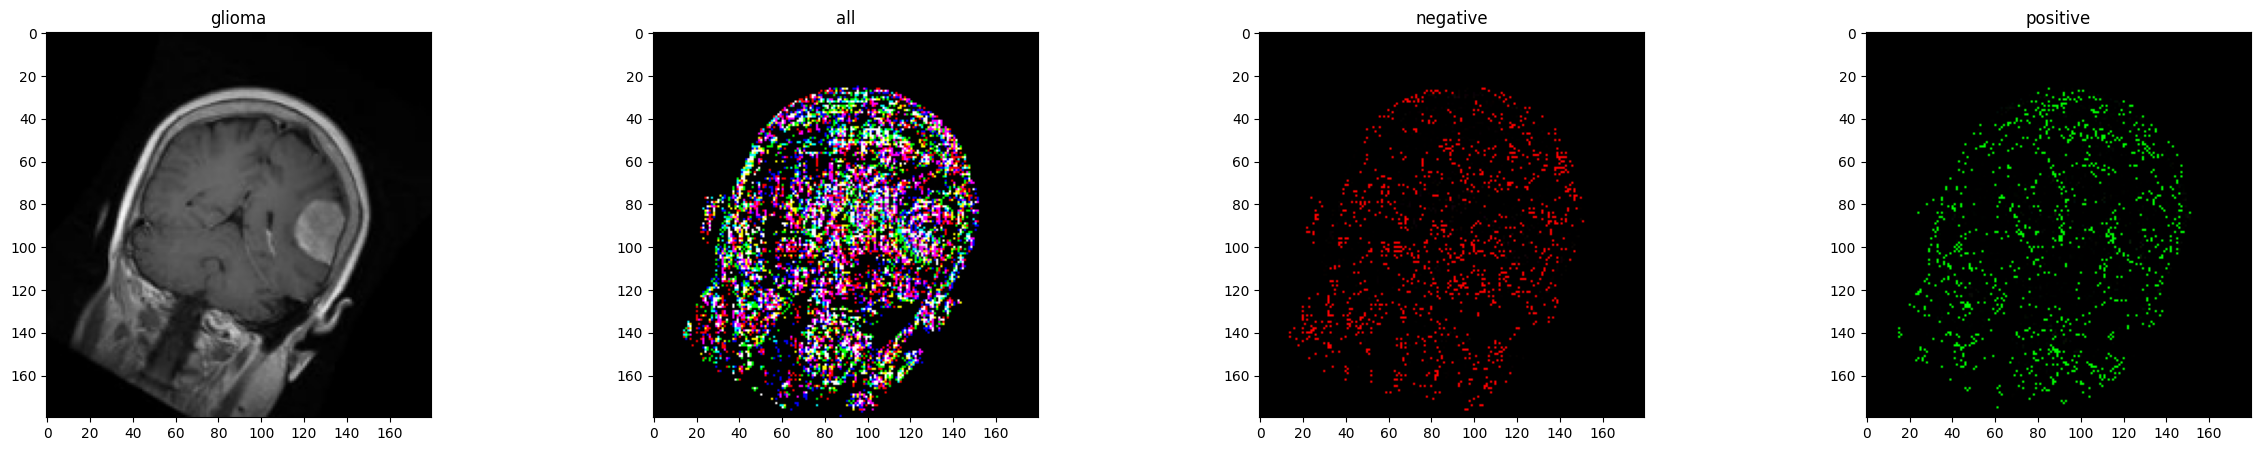

In [ ]:
images, labels = create_color_map_igrad(model, '/content/Training/meningioma/M_100_RO_.jpg')
show_pack_of_images(images, labels)

In [ ]:
img = images[3].copy()
original = images[0].copy()

result = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
result = cv2.blur(result, (5,5));

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)
ret, result = cv2.threshold(result, 0.3 * maxVal, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

for element in contours:
  if 150 > len(element) > 35:
    color = (255, 0, 0)
    x, y, w, h = cv2.boundingRect(element)
    cv2.rectangle(original, (x - 2, y - 2), (x + w + 1, y + h + 1), color, 1)

In [ ]:
def custom_recal(model, data_loader, classes):
    table = np.zeros(16).reshape(4, 4)

    for images, labels in tqdm(validation_data_loader):
        with torch.no_grad():
            predicted = model(images)
            for y_true, y_pred in zip(labels, predicted):
                _, index = torch.topk(y_pred, 1)
                index.squeeze_()
                table[y_true, index] += 1
    TP = np.sum(table.diagonal())
    FN = 0
    for i in range(len(table)):
        for j in range(len(table[i])):
            if j > i:
                FN += table[i][j]
    recal = TP / (TP + FN)

    return recal, table

model.to(device)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
recal, table = custom_recal(model, validation_data_loader, classes)
recal

  0%|          | 0/482 [00:00<?, ?it/s]

0.9867072833010246